# Project 1, Part 5, Data Visualization



# Included Modules and Packages

Code cell containing your includes for modules and packages

In [26]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import psycopg2

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [6]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)
    

In [7]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

# 1.5 Example of a Data Visualization created using Python

The data science team would like for you to create an example of a data visualization using Python from data in a Pandas dataframe containing data from an SQL query.

Write 1 and only 1 query.  Note that the query may have as many subqueries, including "with" clauses, as you wish.  Any query of your choosing.  You can write a query from scratch.  You can use a query from a previous problem in this project.  You can use a query from the labs.  The idea is to come up with a query whose resulting data will make for an excellent quality data visualization. 

Ensure that when you check this Juptyer Notebook into GitHub that the query results in the Pandas dataframe are clearly visible in GitHub.  Note: When a query result has a large number of rows, Pandas will only display the first 5 rows, a row with ellipses, and the last 5 rows. This is ok.

Once you have the data in a Pandas dataframe, you may write as much Python code and use as many code cells as you wish to produce the data visualization.

You may only use Python modules that are currently installed in the Anaconda Docker container.  You may not install additional modules or any other software.

All work must be done in Docker in your VM in AWS.  You may not use any external data visualization systems, such as Tableau, etc.

You may use any code from the labs to pattern your code after, however for the data visualization, you cannot wholesale copy a data visualization from the labs.

Ensure that it is properly titled, including titles for axes if present.

Ensure that when you check this Juptyer Notebook into GitHub that the data visualization is clearly visible.  

If you want to use Google Maps for your data visualization, this is fine, however, the image will not show up in GitHub.  So, just save the image to an image file, include it in the repo, and add a markdown cell to display the image file. Also with Google Maps, do NOT check gmap_api_key.txt into GitHub for security reasons.  If the grader needs to run it, they will supply their own gmap_api_key.txt.


In [16]:
rollback_before_flag = True
rollback_after_flag = True

query = """

with 

  subquery_holidays_plus_minus_7 as 
    (
      select
        h.description as holiday_name,
        my_date::date as date_analyzed,
        extract(dow from my_date) as dow,
        to_char(my_date, 'Day') as day_of_week

    from generate_series('2020-01-01', '2020-12-31', '1 day'::interval) as my_date
        join holidays as h
        on my_date between h.holiday_date - 7 and h.holiday_date + 7

    ),
          
  subquery_expected_sales as
    (
    
    select  
        extract(dow from sale_date) as dow,
        to_char(sale_date, 'Day') as day_of_week,
        round(avg(sales_dollars)) as expected_sales_dollars

    from (select sale_date, sum(total_amount) as sales_dollars
          from sales
          group by sale_date) as sd

        group by dow, day_of_week

    ),
          
  subquery_actual_sales as
    (
       (select
    sale_date,
    sum(total_amount) as sales_dollars
        from sales
        group by sale_date)

    union

      (select 
       h.holiday_date as sale_date,
       0 as sales_dollars
            from holidays as h
            where h.holiday_date not in (select distinct sale_date from sales)     
)

   )
    
select 

   holiday_name,
    a.date_analyzed as date_analyzed,
    a.day_of_week,
    sales_dollars as actual_sales_dollars,
    expected_sales_dollars,
    (sales_dollars/expected_sales_dollars) as ratio_actual_expected
    
from 

subquery_holidays_plus_minus_7 as a
join subquery_expected_sales as b
    on a.day_of_week = b.day_of_week
join subquery_actual_sales as c
    on a.date_analyzed = c.sale_date


order by date_analyzed

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,holiday_name,date_analyzed,day_of_week,actual_sales_dollars,expected_sales_dollars,ratio_actual_expected
0,New Year's Day,2020-01-01,Wednesday,133776,263256,0.508159
1,New Year's Day,2020-01-02,Thursday,261120,266051,0.981466
2,New Year's Day,2020-01-03,Friday,263076,252522,1.041794
3,New Year's Day,2020-01-04,Saturday,400368,373490,1.071964
4,New Year's Day,2020-01-05,Sunday,394992,357482,1.104928
...,...,...,...,...,...,...
167,Christmas,2020-12-27,Sunday,396096,357482,1.108017
168,Christmas,2020-12-28,Monday,264852,253225,1.045916
169,Christmas,2020-12-29,Tuesday,130440,132603,0.983688
170,Christmas,2020-12-30,Wednesday,263424,263256,1.000638


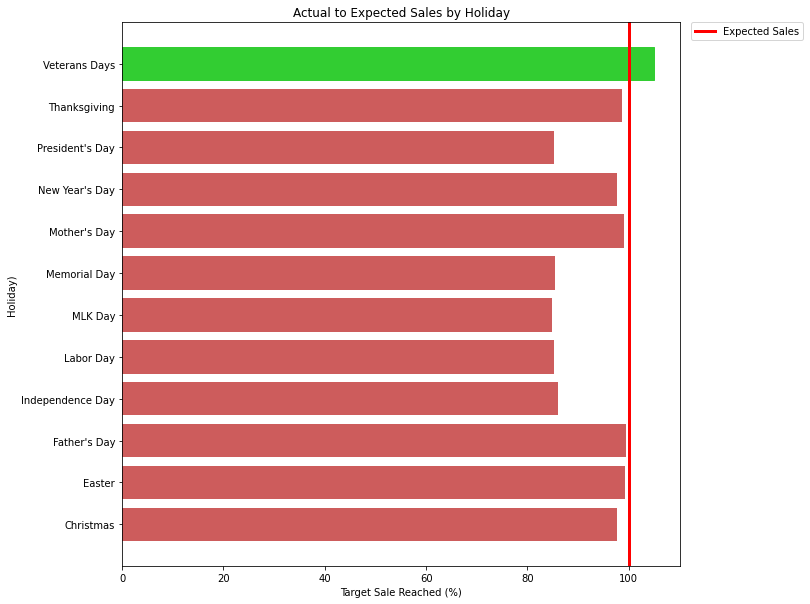

In [68]:
# Use as many code cells as you need to create and display your data visualization
grouped = df.groupby("holiday_name").sum()
grouped["new"] = grouped["actual_sales_dollars"] / grouped["expected_sales_dollars"]
grouped = grouped.reset_index()

plt.figure(figsize=(10,10))
k = plt.barh(grouped['holiday_name'], grouped['new']*100, color = "indianred")
plt.axvline(x = 100, color = 'r', label = 'Expected Sales', linewidth=3)
plt.title('Actual to Expected Sales by Holiday')
plt.xlabel('Target Sale Reached (%)')
plt.ylabel('Holiday)')
k[-1].set_color("limegreen")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()